# Proyecto Deep Learning Spotify: Tarea 1

## Configuración del entorno

In [1]:
%pip install -r ../requirements.txt

  Using cached absl_py-2.4.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.5-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.13.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached markdown-3.10.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached rich-14.3.2-p


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Carga y exploración inicial de los datos

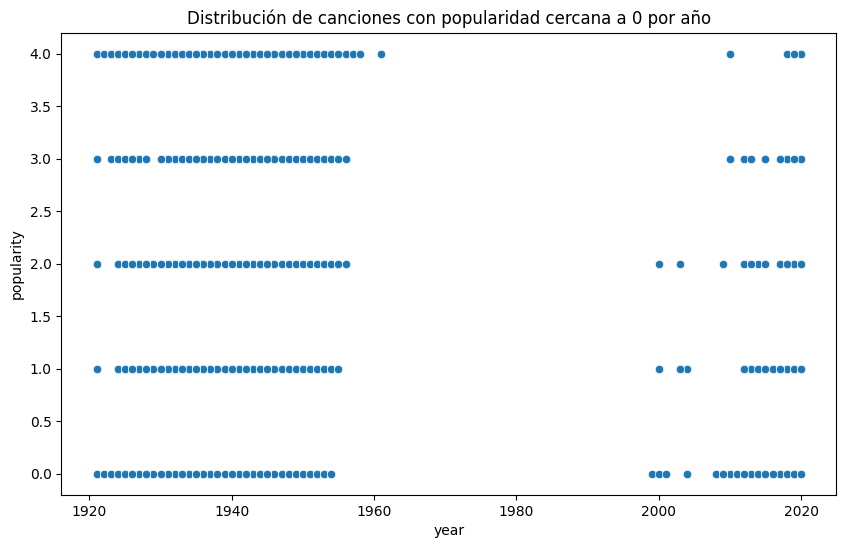

In [3]:
df = pd.read_csv(r'..\data\data.csv')

# Mostramos la distribución de canciones con popularidad cercana a 0 por año
plt.figure(figsize=(10,6))
sns.scatterplot(data=df[df['popularity'] < 5], x='year', y='popularity')
plt.title("Distribución de canciones con popularidad cercana a 0 por año")
plt.show()

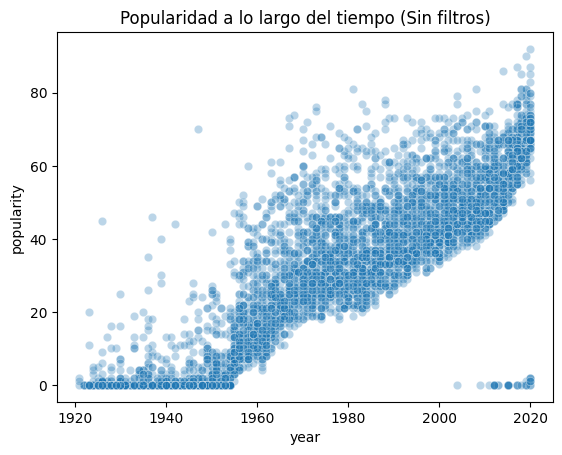

In [4]:
# Gráfico de TODOS los datos (una muestra aleatoria para no saturar)
sns.scatterplot(data=df.sample(5000), x='year', y='popularity', alpha=0.3)
plt.title("Popularidad a lo largo del tiempo (Sin filtros)")
plt.show()

## Limpieza inteligente de Datos

In [5]:
# Asumimos que df es vuestro dataset completo cargado

# 1. ANÁLISIS DE "BASURA"
# Vamos a ver qué pinta tienen esas muestras sospechosas
muestras_cortas = df[df['duration_ms'] < 60000] # Menos de 1 min
muestras_habladas = df[df['speechiness'] > 0.9] # Casi todo voz
muestras_sin_tempo = df[df['tempo'] == 0]       # Error técnico

print(f"Canciones de menos de 1 minuto: {len(muestras_cortas)}")
print(f"Tracks que son solo voz (audiolibros/charlas): {len(muestras_habladas)}")
print(f"Tracks con tempo 0: {len(muestras_sin_tempo)}")

# 2. APLICACIÓN DE LA LIMPIEZA
# Definimos las condiciones de "Basura"
condicion_basura = (
    (df['duration_ms'] < 40000) |       # Menos de 40 seg (Intros/Ruido)
    (df['speechiness'] > 0.9) |         # Pura voz (No música)
    (df['tempo'] == 0)                  # Error de datos
)

# Nos quedamos con lo que NO es basura
# El símbolo ~ invierte la condición (significa "NO es basura")
df_limpio_final = df[~condicion_basura].copy()

print(f"\nDimensiones antes de limpiar basura: {df.shape}")
print(f"Dimensiones después de limpiar basura: {df_limpio_final.shape}")
print(f"Hemos eliminado {df.shape[0] - df_limpio_final.shape[0]} muestras de 'ruido'.")

# 3. VERIFICACIÓN
# Comprobamos que seguimos teniendo los ceros "buenos" (los antiguos)
ceros_antiguos = df_limpio_final[(df_limpio_final['year'] < 1950) & (df_limpio_final['popularity'] == 0)]
print(f"\nTodavía conservamos {len(ceros_antiguos)} canciones antiguas con popularidad 0.")

Canciones de menos de 1 minuto: 1615
Tracks que son solo voz (audiolibros/charlas): 4016
Tracks con tempo 0: 143

Dimensiones antes de limpiar basura: (170653, 19)
Dimensiones después de limpiar basura: (165988, 19)
Hemos eliminado 4665 muestras de 'ruido'.

Todavía conservamos 19073 canciones antiguas con popularidad 0.


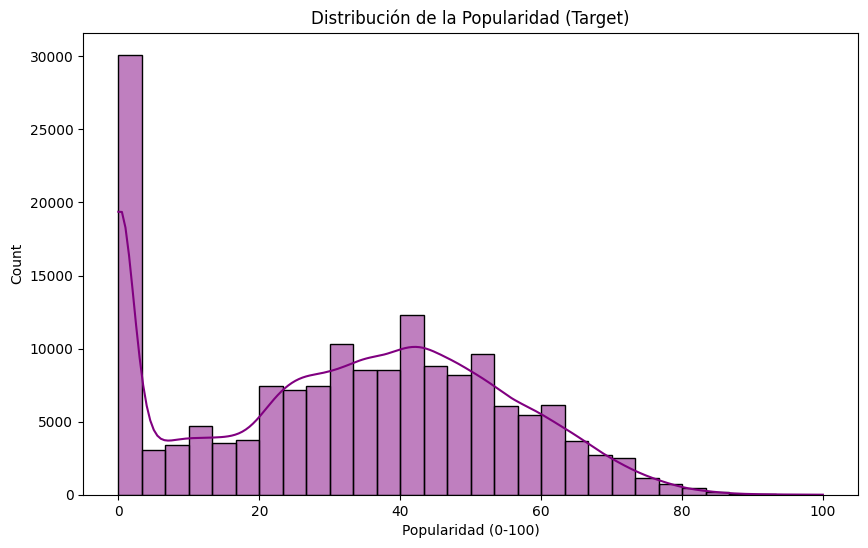

count    165988.000000
mean         32.188447
std          21.563531
min           0.000000
25%          14.000000
50%          34.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64


In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df_limpio_final['popularity'], kde=True, bins=30, color='purple')
plt.title('Distribución de la Popularidad (Target)')
plt.xlabel('Popularidad (0-100)')
plt.show()

# Estadísticos básicos
print(df_limpio_final['popularity'].describe())

## Preprocesamiento y estudio de datos

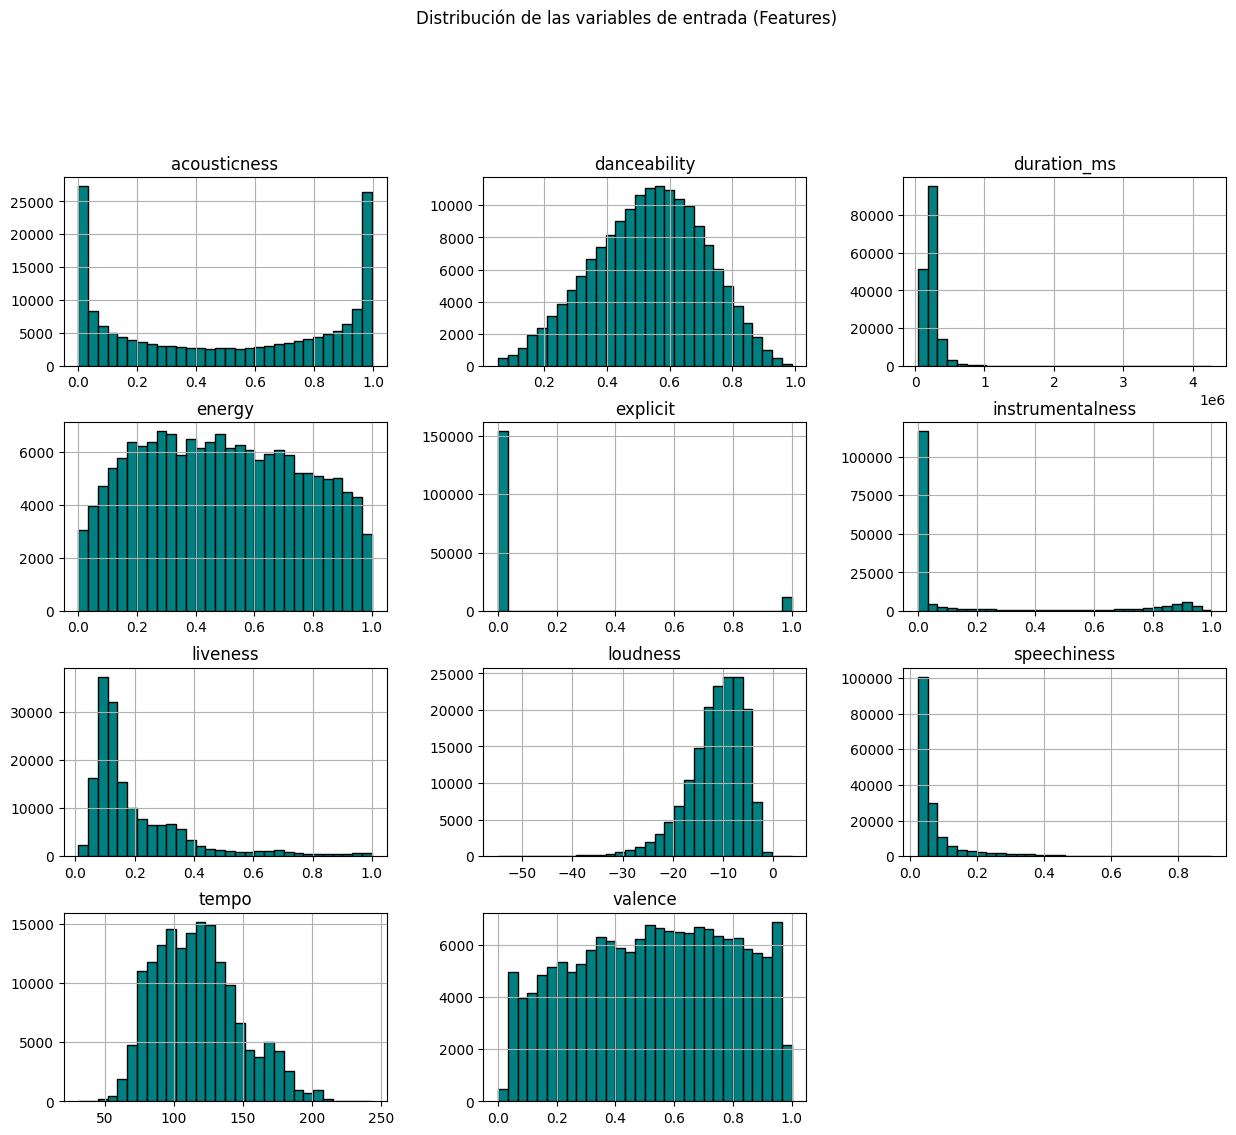

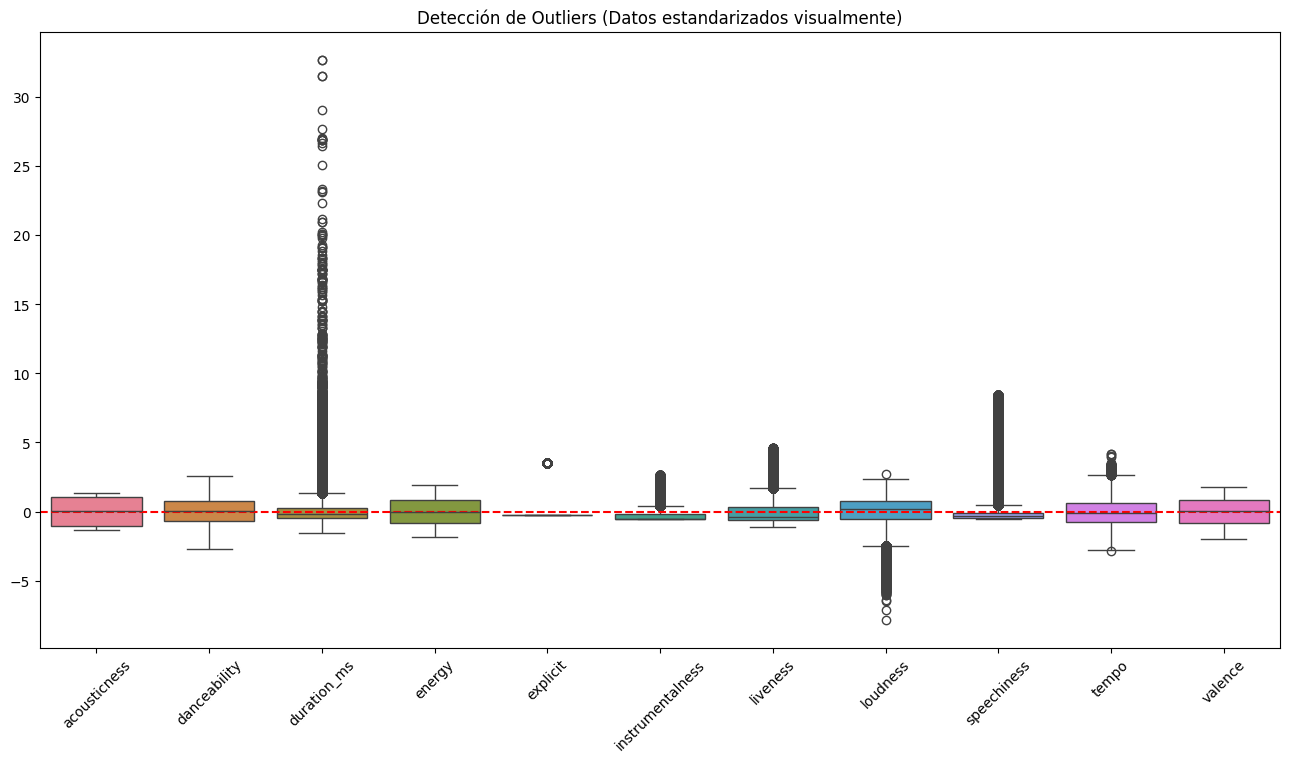

In [7]:
# Definimos las columnas numéricas que usaremos para predecir
# Quitamos 'popularity' (es la Y) y 'year' (ya sabemos que está bien)
features = ['acousticness', 'danceability', 'duration_ms', 'energy',
            'explicit', 'instrumentalness', 'liveness', 'loudness',
            'speechiness', 'tempo', 'valence']

# 1. HISTOGRAMAS (¿Cómo se distribuyen los datos?)
df_limpio_final[features].hist(figsize=(15, 12), bins=30, color='teal', edgecolor='black')
plt.suptitle('Distribución de las variables de entrada (Features)', y=1.02)
plt.show()

# 2. BOXPLOTS (Para ver Outliers y Escalas)
plt.figure(figsize=(16, 8))
# Usamos escala logarítmica para duration_ms porque es GIGANTE comparado con el resto
# O mejor: Estandarizamos visualmente solo para el gráfico para poder compararlas
df_norm_visual = (df_limpio_final[features] - df_limpio_final[features].mean()) / df_limpio_final[features].std()

sns.boxplot(data=df_norm_visual)
plt.xticks(rotation=45)
plt.title('Detección de Outliers (Datos estandarizados visualmente)')
plt.axhline(y=0, color='r', linestyle='--') # Línea de la media
plt.show()

## SELECCIÓN DE VARIABLES (X e y)


In [ ]:

# 1. Definimos la variable objetivo (Target)
target = 'popularity'

# 2. Definimos las columnas que NO son predictivas (Metadatos)
# Estas se eliminan de X porque son texto (IDs, Nombres) o es el propio target
cols_to_drop = [
    'popularity',   # El target
    'id',           # ID único (no aporta información musical)
    'name',         # Nombre canción (demasiada cardinalidad)
    'artists',      # Nombre artistas (podríamos utilizarlo en modelos avanzados)
    'id_artists',   # ID artistas
    'release_date', # Fecha exacta (ya tenemos 'year')
    'mode'          # Lo quitamos por si da problemas
]

# 3. Creación de X (entradas) e y (salidas)
X = df_limpio_final.drop(columns=cols_to_drop, errors='ignore')
y = df_limpio_final[target]

print("--- DIMENSIONES FINALES ---")
print(f"X (Entradas): {X.shape}")
print(f"y (Salidas):  {y.shape}")

# Verificación visual
print("\nEjemplo de X (Entradas):")
display(X.head(3))
print("\nEjemplo de y (Salidas):")
display(y.head(3))

--- DIMENSIONES FINALES ---
X (Entradas): (165988, 13)
y (Salidas):  (165988,)

Ejemplo de X (Entradas):


,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,speechiness,tempo
0,0.0594,1921,0.982,0.279,831667,0.211,0,0.878,10,0.665,-20.096,0.0366,80.954
1,0.9630,1921,0.732,0.819,180533,0.341,0,0.000,7,0.160,-12.441,0.4150,60.936
2,0.0394,1921,0.961,0.328,500062,0.166,0,0.913,3,0.101,-14.850,0.0339,110.339



Ejemplo de y (Salidas):


0    4
1    5
2    5
Name: popularity, dtype: int64